# DNN: analysis with Keras of 2D data

In [60]:
import numpy as np #Always usefull and to be used

from keras.models import Sequential
from keras.layers import Dense, Dropout

import matplotlib as mpl
import matplotlib.pyplot as plt
# default font
plt.rcParams['font.size'] = 13

%run useful.py

# training data
perc_train = 0.8

## Read data

(2000, 8)
8
[1.83918812 2.04560279 5.67725029 5.95544703 9.6451452  6.53177097
 7.48906638 6.53569871] 1
[7.47714809 9.61306736 0.08388298 1.06444377 2.98703714 6.56411183
 8.09812553 8.72175914] 0
[9.64647597 7.23685347 6.42475328 7.17453621 4.67599007 3.25584678
 4.39644606 7.29689083] 0
[9.94014586 6.76873712 7.90822518 1.70914258 0.26849276 8.00370244
 9.03722538 0.2467621 ] 0
[4.91747318 5.26255167 5.9636601  0.51957545 8.95089528 7.2826618
 8.18350011 5.00222753] 1
data: 2000
train: 1600


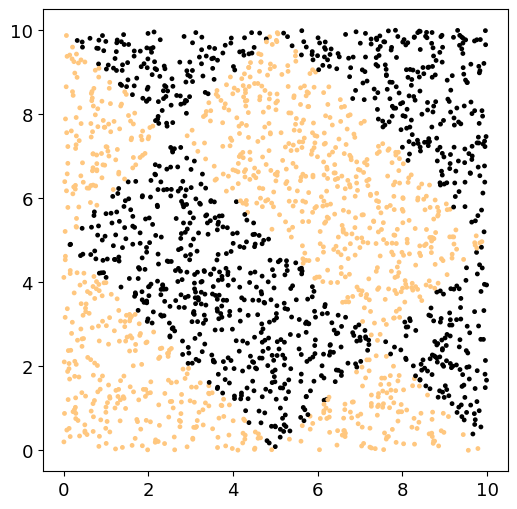

In [61]:
# Keras works with numpy arrays: just use them from the start

TYPE=3
# data point size
L=8
# span of each component
B=10
x = np.loadtxt(filename("data",L,TYPE), delimiter=' ')
y = np.loadtxt(filename("labels",L,TYPE), delimiter=' ')
y = y.astype("int")
print(x.shape)
N = len(x)
# average and std.dev.
x_mean = np.mean(x,axis=0)
x_std  = np.std(x,axis=0)


# dim. of a sample
L = len(x[0])
print(L)

for i in range(5):
    print(x[i],y[i])

N_train = int(perc_train * N)
print(f'data: {N}\ntrain: {N_train}')

plot_data(x,y)

## Standardize data

In [62]:
print("before rescaling:\nmean value=", x_mean,"\nstd. dev.=",x_std)
def Standardize(x,m,s):
    """
    rescale each component using its mean and standard deviation
    """
    N = len(x)
    # assuming len(m)=len(s)=len(x[0])
    mm,ss = np.tile(m,(N,1)), np.tile(s,(N,1))
    return (x-mm)/ss
x = Standardize(x,x_mean,x_std)
print("after rescaling:\nmean value=", x.mean(axis=0),"\nstd. dev.=",x.std(axis=0))

before rescaling:
mean value= [5.01860571 5.01726228 5.02153857 5.08947968 5.10248206 5.03670082
 4.88645281 5.05411547] 
std. dev.= [2.86912607 2.89535235 2.87312372 2.86324409 2.90278676 2.91948328
 2.92549254 2.89281292]
after rescaling:
mean value= [ 2.53633226e-15  9.27924404e-16 -1.44884105e-15 -2.38371996e-15
 -2.85274582e-15 -2.02196593e-15 -1.09010023e-15 -1.53632662e-15] 
std. dev.= [1. 1. 1. 1. 1. 1. 1. 1.]


## Split training and test data

In [63]:
(x_train, y_train) = (x[0:N_train],y[0:N_train])
(x_valid, y_valid) = (x[N_train:],y[N_train:])
print("Train:",len(x_train),"\t Validation:",len(x_valid))
print(x_train)

Train: 1600 	 Validation: 400
[[-1.10814845 -1.02635505  0.22822258 ...  0.51210095  0.88963261
   0.51216006]
 [ 0.85689591  1.58730425 -1.71856699 ...  0.52317855  1.09782291
   1.26784682]
 [ 1.61298951  0.76660486  0.48839342 ... -0.60998946 -0.16749547
   0.77529222]
 ...
 [-0.27184292  0.67259061  1.19944117 ... -1.21070508  1.34964656
   0.98899467]
 [-1.73560185  0.99135948  1.67404318 ... -0.33492373  0.9869345
  -0.7116746 ]
 [ 1.19833473  0.4564702  -1.21113227 ... -0.24780706  1.34121245
   0.52916834]]


## Alternative Data Augmentation 

In [106]:
# max_values = np.max(x_train, axis=0)
# min_values = np.min(x_train, axis=0)
def augment_data(x_train, y_train, M=3):
    augmented_x = []
    augmented_y = []

    for i in range( np.shape(y_train)[0] ):
        x, y = x_train[i], y_train[i]
        eq_colored_x = x_train[y_train == y]
        distances = [np.sqrt(np.sum(x**2 + z**2)) for z in eq_colored_x]

        indx = np.argmin(distances)
        closest_x = eq_colored_x[indx]

        for _ in range(M):
            new_x = [np.random.uniform( min(x[j], closest_x[j]),  max(x[j], closest_x[j]) ) for j in range(L)]
            augmented_x.append(new_x)
            augmented_y.append(y)

    return np.array(augmented_x), np.array(augmented_y)

(200, 8)
augmented data 
 (200, 8)


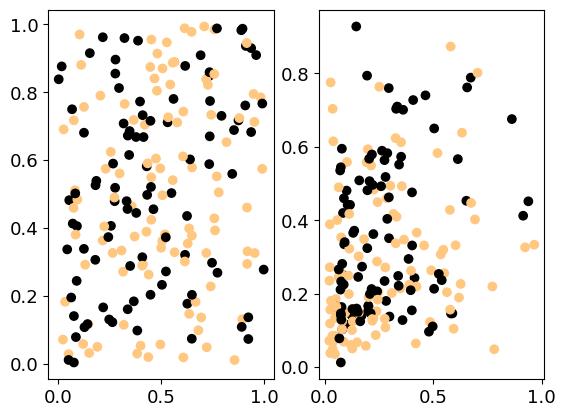

In [ ]:
fig, axes = plt.subplots(1, 2)

data = np.random.random((200, 8))
dummy_labels = np.random.choice((0, 1), size=200)
print(np.shape(data))
axes[0].scatter(data[:, 0], data[:, 1], c=dummy_labels)

augm_data, augm_labels = augment_data(data, dummy_labels, 1)
print("augmented data \n",np.shape(augm_data))
axes[1].scatter(augm_data[:, 0], augm_data[:, 1], c=augm_labels)


## Define the model with Keras / Tensorflow

In [47]:
# reproducibility (?)
np.random.seed(12345)
import tensorflow.random as tf_r
tf_r.set_seed(12345)

# We use case 1
CASE=1

if CASE==1:
    model = Sequential()
    model.add(Dense(L,input_shape=(L,),activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(20,activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(20,activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1,activation='sigmoid')) #sigmoid because we want a result between 0 and 1
    nepoch=400
# as case 1 but one layer shorter
if CASE==2:
    model = Sequential()
    model.add(Dense(L,input_shape=(L,),activation='relu'))
    model.add(Dense(40,activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(20,activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1,activation='sigmoid'))
    nepoch=400
#deeper
if CASE==3:
    model = Sequential()
    model.add(Dense(L,input_shape=(L,),activation='relu'))
    model.add(Dense(10,activation='relu'))
    model.add(Dense(10,activation='relu'))
    model.add(Dense(10,activation='relu'))
    model.add(Dense(10,activation='relu'))
    model.add(Dense(10,activation='relu'))
    model.add(Dense(10,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    nepoch=400
    
print(model.summary())

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,113 (4.35 KB)

 Trainable params: 1,113 (4.35 KB)

 Non-trainable params: 0 (0.00 B)

None


## Optimization method and cost function

In [12]:
model.compile(loss='binary_crossentropy',
              optimizer='RMSprop',
              #optimizer='adam',
              metrics=['accuracy'])

## Training

In [14]:
fit = model.fit(x_train, y_train,
               epochs = nepoch, batch_size = 50,
               validation_data=(x_valid,y_valid),
               verbose=1)

Epoch 1/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5105 - loss: 0.7122 - val_accuracy: 0.5000 - val_loss: 0.6888
Epoch 2/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - accuracy: 0.4593 - loss: 0.6958 - val_accuracy: 0.5250 - val_loss: 0.6867
Epoch 3/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - accuracy: 0.5223 - loss: 0.6920 - val_accuracy: 0.5250 - val_loss: 0.6848
Epoch 4/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - accuracy: 0.5258 - loss: 0.6835 - val_accuracy: 0.5375 - val_loss: 0.6834
Epoch 5/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - accuracy: 0.5244 - loss: 0.6899 - val_accuracy: 0.5525 - val_loss: 0.6829
Epoch 6/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - accuracy: 0.5472 - loss: 0.6880 - val_accuracy: 0.5550 - val_loss: 0.6822
Epoch 7/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - accuracy: 0.5368 - loss: 0.6825 - val_accuracy: 0.5625 - val_loss: 0.6815
Epoch 8/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - accuracy: 0.5596 - loss: 0.6831 - val_accura

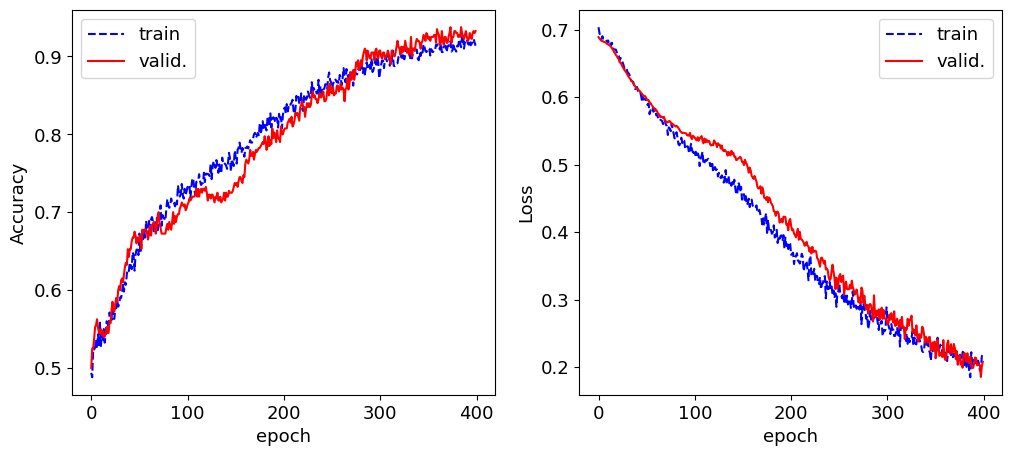

In [15]:
fig,AX=plt.subplots(1,2,figsize=(12,5.))
ax=AX[0]
ax.plot(fit.history['accuracy'],label="train",c="b",ls="--")
ax.plot(fit.history['val_accuracy'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")
ax.legend()
ax=AX[1]
ax.plot(fit.history['loss'],label="train",c="b",ls="--")
ax.plot(fit.history['val_loss'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()

## Grid to show preditions

319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


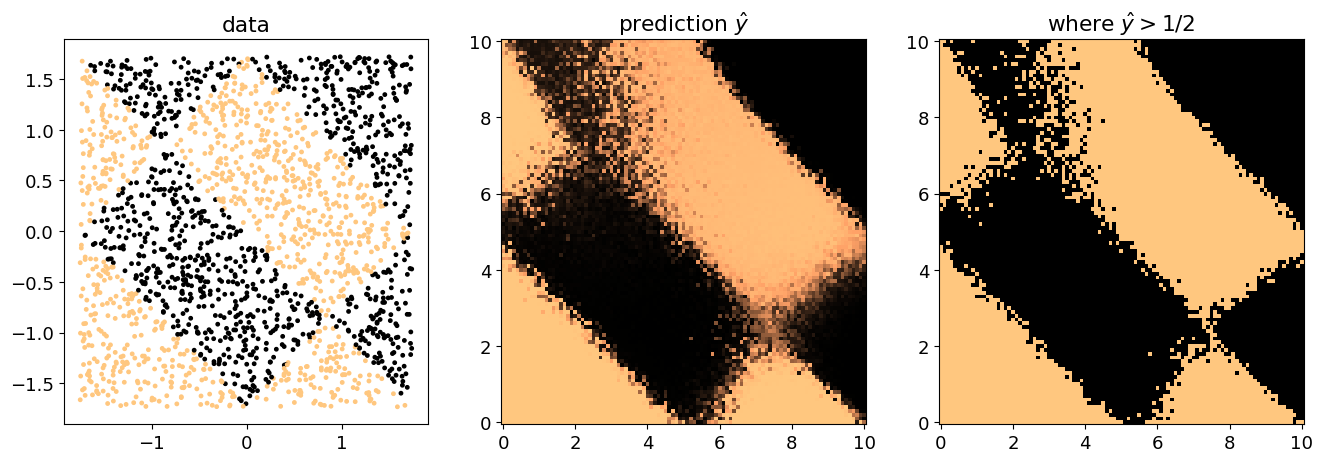

remember: these are 2 out of L=8 dimensions, of which L-2 contain random noise


In [17]:
dX = .1
X1 = np.arange(0,10+dX, dX)
LG = len(X1)
X, Y = np.meshgrid(X1, X1)
allXY = np.reshape((np.array((X,Y)).T),(LG**2,2))
grid = np.random.rand(LG**2,L)*B
grid[:,:2] = allXY
grid_r=Standardize(grid,x_mean,x_std)

pred = model.predict(grid_r)

fig,AX=plt.subplots(1,3,figsize=(16,5.))
ax=AX[0]
ax.scatter(x[:,0],x[:,1],c=y,s=6)
ax.set_title("data")
ax=AX[1]
ax.pcolormesh(X1,X1,pred.reshape((LG, LG)))
ax.set_title("prediction $\\hat y$")
ax=AX[2]
pred01=np.copy(pred)
pred01[pred>0.5]=1
pred01[pred<=0.5]=0
ax.pcolormesh(X1,X1,pred01.reshape((LG, LG)))
ax.set_title("where $\\hat y > 1/2$")
plt.show()
print(f"remember: these are 2 out of L={L} dimensions, of which L-2 contain random noise")

In [18]:
import keras_tuner
import keras
from keras import layers

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten())
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 6)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=10, max_value=30, step=5),
                activation=hp.Choice("activation", ["relu", "sigmoid", "tanh", "elu"]),
            )
        )
        model.add(layers.Dropout(rate=hp.Float("dropout", min_value = 0, max_value = 0.2, step = 0.05)))
        
    model.add(layers.Dense(1, activation="sigmoid")) #Layer output --> importante che sia della size giusta
    learning_rate = hp.Float("lr", min_value=1e-6, max_value=1e-1, sampling="log")
    model.compile(
        optimizer=hp.Choice("optimizer", ["adam", "RMSprop", "Nesterov"]), loss="binary_crossentropy",
        metrics=["accuracy"])
    return model


build_model(keras_tuner.HyperParameters())

tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=50,
    executions_per_trial=1,
    overwrite=True,
)

tuner.search_space_summary()

tuner.search(x_train, y_train, batch_size = 50, epochs = 320, validation_data=(x_valid,y_valid), verbose=1)

Trial 5 Complete [00h 00m 00s]

Best val_accuracy So Far: 0.8399999737739563
Total elapsed time: 00h 00m 23s


/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


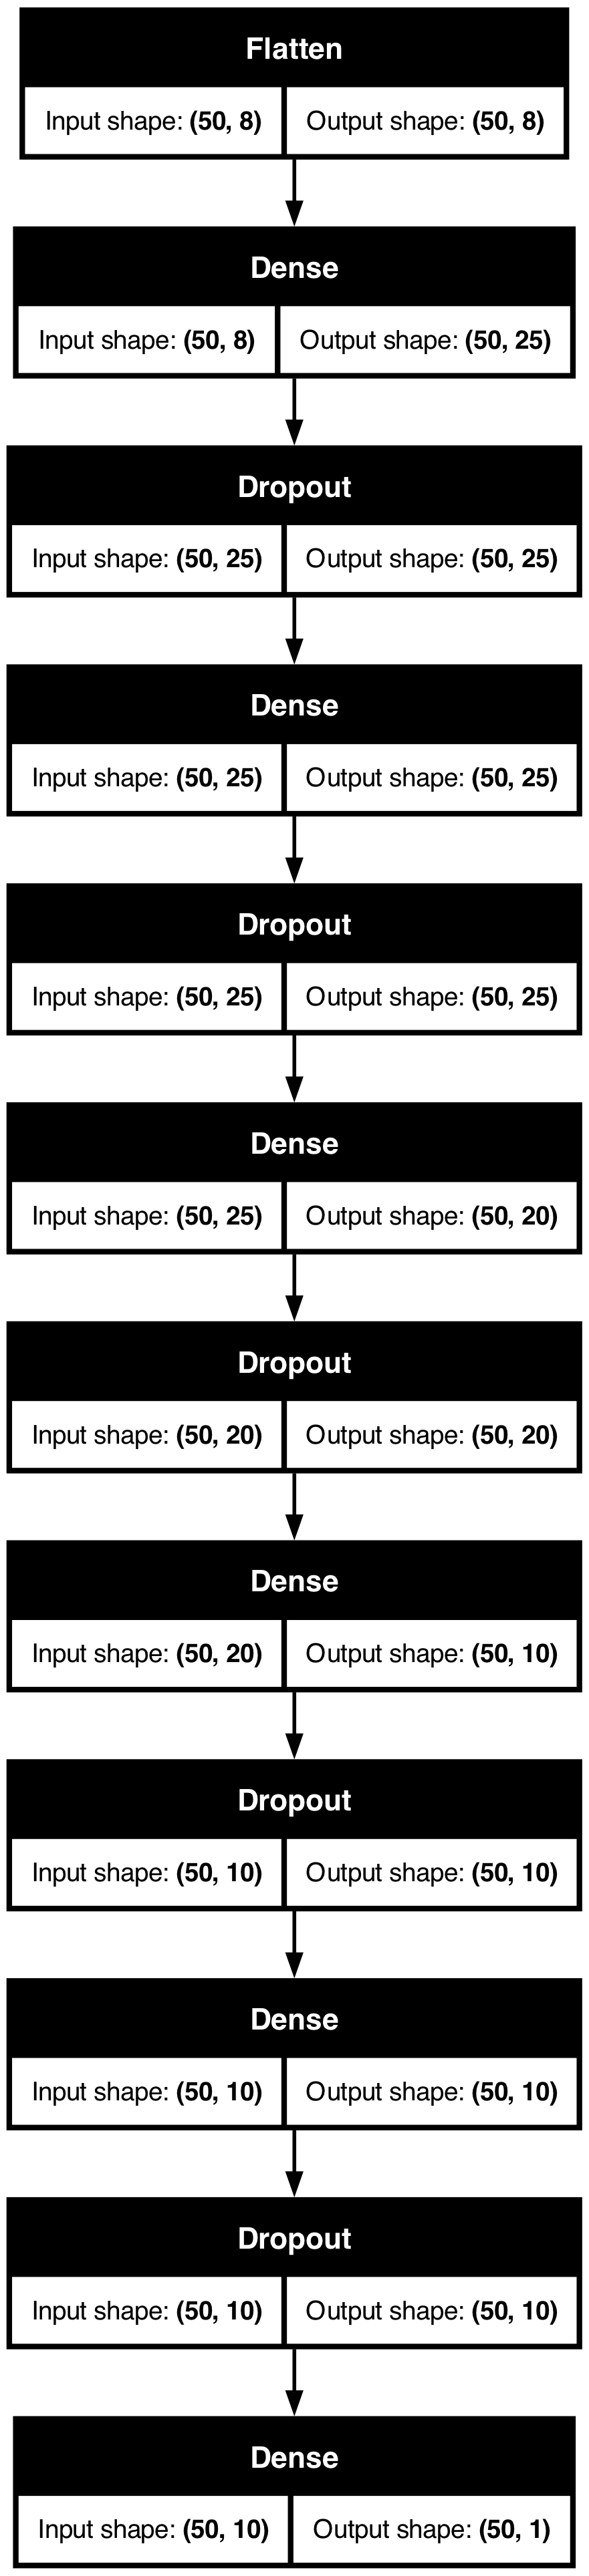

In [37]:
#A way to visualize the NN
model = tuner.get_best_models(num_models=1)
keras.utils.plot_model(model[0], show_shapes=True)